# The workflow of this code consists of three parts:
# 1. Data Cleaning - handling of missing data, coverting categorical features to numerical
# 2. Exploratory Data Analysis - Visualize relationsip and perform feature importance
# 3. Machine Learning Models - choose models and optimize



In [42]:
# PART I: DATA CLEANING
# This part includes converting data types, removing nulls & duplicates, feature engineering (create agg. values like profitetc) and converting categorical features to numerical
# Import Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

import numpy as np


# Ignore all warning messages
warnings.filterwarnings('ignore')


In [43]:
from google.colab import files

uploaded = files.upload()


Saving movie_metadata.csv to movie_metadata (1).csv


In [44]:
# Please UPLOAD the "movie_metadata.csv" file from the Resources folder to the same directory level as this code in Google Colab.

# Load the uploaded Excel file.
file_path = 'movie_metadata.csv'
# Set variable as the origibnal data
data_origin = pd.read_csv(file_path)
# Create a copy of the original data to keep it intactin case of any bugs
data = data_origin.copy()
# Display the first few rows of the dataset to understand its structure
data.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [45]:
# Clean the 'movie_title' column by removing 'Â' and any additional whitespace at the end
data['movie_title'] = data['movie_title'].str.replace('Â', '', regex=True).str.strip()
# Change the order of the columns and drop

In [46]:
# Change column order starting with defining the new column order
# Drop columns 'movie_imdb_link' and 'aspect_ratio'.
new_column_order = [
    'movie_title', 'gross', 'budget',  # Main movie details
    'actor_1_name', 'actor_1_facebook_likes',  # Actor 1 details
    'actor_2_name', 'actor_2_facebook_likes',  # Actor 2 details
    'actor_3_name', 'actor_3_facebook_likes',  # Actor 3 details
    'director_name', 'director_facebook_likes',  # Director details
    'duration', 'title_year', 'num_critic_for_reviews', 'num_user_for_reviews',  # Movie-specific details
    'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster',  # User and cast data
    'movie_facebook_likes',  # Add this column here
    'plot_keywords', 'genres', 'language', 'country', 'content_rating', 'imdb_score', 'color',  # Other features
]

# Reorder the DataFrame based on the new column order
data = data[new_column_order]

# Check the first three of our restructured data
print(data.head(3))

                                movie_title        gross       budget  \
0                                    Avatar  760505847.0  237000000.0   
1  Pirates of the Caribbean: At World's End  309404152.0  300000000.0   
2                                   Spectre  200074175.0  245000000.0   

      actor_1_name  actor_1_facebook_likes      actor_2_name  \
0      CCH Pounder                  1000.0  Joel David Moore   
1      Johnny Depp                 40000.0     Orlando Bloom   
2  Christoph Waltz                 11000.0      Rory Kinnear   

   actor_2_facebook_likes      actor_3_name  actor_3_facebook_likes  \
0                   936.0         Wes Studi                   855.0   
1                  5000.0    Jack Davenport                  1000.0   
2                   393.0  Stephanie Sigman                   161.0   

    director_name  ...  cast_total_facebook_likes  facenumber_in_poster  \
0   James Cameron  ...                       4834                   0.0   
1  Gore Verbins

In [47]:
num_rows = data.shape[0]
print("Number of rows:", num_rows)


Number of rows: 5043


In [48]:
# Make a copy of the data for debugging purposes
m_data = data.copy()
# Filter the data to include only rows where the 'country' column is equal to 'USA'
filtered_data = m_data[data['country'] == 'USA']
# We would like to limit the scope for the US only to remove biasis of foreign movies making less in the US may not be their primary target

In [49]:
# Fill missing values for string columns like 'director_name' with 'Unknown'
filtered_data.loc[:, ['director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name']] = filtered_data.loc[:, ['director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name']].fillna('Unknown')

# Replace 'Unrated' with 'Not rated' in the 'content_rating' column
filtered_data.loc[:, 'content_rating'] = filtered_data['content_rating'].replace('Unrated', 'Not rated')

# Drop rows with any other missing values to create a more accurate machine learning model
transformed_data = filtered_data.dropna()

In [50]:
# Get the number of rows in the DataFrame to verify data size and successful data type conversion for 'gross' and 'budget' columns
# Check if any other values need conversion
num_rows = transformed_data.shape[0]

# Get the data types of each column
data_types = transformed_data.dtypes

# Display the results
print(f"Number of the remaining rows: {num_rows}")
print("\nData types of each column:")
print(data_types)

Number of the remaining rows: 3026

Data types of each column:
movie_title                   object
gross                        float64
budget                       float64
actor_1_name                  object
actor_1_facebook_likes       float64
actor_2_name                  object
actor_2_facebook_likes       float64
actor_3_name                  object
actor_3_facebook_likes       float64
director_name                 object
director_facebook_likes      float64
duration                     float64
title_year                   float64
num_critic_for_reviews       float64
num_user_for_reviews         float64
num_voted_users                int64
cast_total_facebook_likes      int64
facenumber_in_poster         float64
movie_facebook_likes           int64
plot_keywords                 object
genres                        object
language                      object
country                       object
content_rating                object
imdb_score                   float64
color       

In [51]:
# Convert 'budget' and 'gross' columns to integers. Rounded to the whole numbers
data['budget'] = pd.to_numeric(data['budget'], errors='coerce').fillna(0).round(0).astype(int)
data['gross'] = pd.to_numeric(data['gross'], errors='coerce').fillna(0).round(0).astype(int)

# Use .loc to modify the data types in other columns without triggering Warning messages
transformed_data.loc[:, 'actor_1_facebook_likes'] = pd.to_numeric(transformed_data['actor_1_facebook_likes'], errors='coerce').fillna(0).round(0).astype(int)
transformed_data.loc[:, 'actor_2_facebook_likes'] = pd.to_numeric(transformed_data['actor_2_facebook_likes'], errors='coerce').fillna(0).round(0).astype(int)
transformed_data.loc[:, 'actor_3_facebook_likes'] = pd.to_numeric(transformed_data['actor_3_facebook_likes'], errors='coerce').fillna(0).round(0).astype(int)
transformed_data.loc[:, 'num_critic_for_reviews'] = pd.to_numeric(transformed_data['num_critic_for_reviews'], errors='coerce').fillna(0).round(0).astype(int)
transformed_data.loc[:, 'num_user_for_reviews'] = pd.to_numeric(transformed_data['num_user_for_reviews'], errors='coerce').fillna(0).round(0).astype(int)
transformed_data.loc[:, 'facenumber_in_poster'] = pd.to_numeric(transformed_data['facenumber_in_poster'], errors='coerce').fillna(0).round(0).astype(int)

# Convert the 'title_year' column to integer format, ensuring proper handling of missing values
transformed_data['title_year'] = pd.to_numeric(transformed_data['title_year'], errors='coerce').astype('Int64')

# Display the first 5 rows of the data
transformed_data.head()


,movie_title,gross,budget,actor_1_name,actor_1_facebook_likes,actor_2_name,actor_2_facebook_likes,actor_3_name,actor_3_facebook_likes,director_name,...,cast_total_facebook_likes,facenumber_in_poster,movie_facebook_likes,plot_keywords,genres,language,country,content_rating,imdb_score,color
0,Avatar,760505847.0,237000000.0,CCH Pounder,1000.0,Joel David Moore,936.0,Wes Studi,855.0,James Cameron,...,4834,0.0,33000,avatar|future|marine|native|paraplegic,Action|Adventure|Fantasy|Sci-Fi,English,USA,PG-13,7.9,Color
1,Pirates of the Caribbean: At World's End,309404152.0,300000000.0,Johnny Depp,40000.0,Orlando Bloom,5000.0,Jack Davenport,1000.0,Gore Verbinski,...,48350,0.0,0,goddess|marriage ceremony|marriage proposal|pi...,Action|Adventure|Fantasy,English,USA,PG-13,7.1,Color
3,The Dark Knight Rises,448130642.0,250000000.0,Tom Hardy,27000.0,Christian Bale,23000.0,Joseph Gordon-Levitt,23000.0,Christopher Nolan,...,106759,0.0,164000,deception|imprisonment|lawlessness|police offi...,Action|Thriller,English,USA,PG-13,8.5,Color
5,John Carter,73058679.0,263700000.0,Daryl Sabara,640.0,Samantha Morton,632.0,Polly Walker,530.0,Andrew Stanton,...,1873,1.0,24000,alien|american civil war|male nipple|mars|prin...,Action|Adventure|Sci-Fi,English,USA,PG-13,6.6,Color
6,Spider-Man 3,336530303.0,258000000.0,J.K. Simmons,24000.0,James Franco,11000.0,Kirsten Dunst,4000.0,Sam Raimi,...,46055,0.0,0,sandman|spider man|symbiote|venom|villain,Action|Adventure|Romance,English,USA,PG-13,6.2,Color


In [52]:
# Remove rows where 'movie_title' has duplicates (keep the first occurrence and drop others)
cleaned_data = transformed_data.drop_duplicates(subset=['movie_title'], keep='first')
# That removes movies wiht identical titles and avoid confusion in our machine learning models if movies names were used more than once.

In [53]:
# Show two first rows and the data size
cleaned_data.shape
print(cleaned_data.head(2))

                                movie_title        gross       budget  \
0                                    Avatar  760505847.0  237000000.0   
1  Pirates of the Caribbean: At World's End  309404152.0  300000000.0   

  actor_1_name  actor_1_facebook_likes      actor_2_name  \
0  CCH Pounder                  1000.0  Joel David Moore   
1  Johnny Depp                 40000.0     Orlando Bloom   

   actor_2_facebook_likes    actor_3_name  actor_3_facebook_likes  \
0                   936.0       Wes Studi                   855.0   
1                  5000.0  Jack Davenport                  1000.0   

    director_name  ...  cast_total_facebook_likes  facenumber_in_poster  \
0   James Cameron  ...                       4834                   0.0   
1  Gore Verbinski  ...                      48350                   0.0   

   movie_facebook_likes                                      plot_keywords  \
0                 33000             avatar|future|marine|native|paraplegic   
1        

In [54]:
# Make a copy of 'cleaned_data' for debugging purposes
# for debugging purposes
cleaned_data = cleaned_data.copy()

# Create a new column for profit using .loc
cleaned_data.loc[:, 'profit'] = cleaned_data['gross'] - cleaned_data['budget']


In [55]:
# Ensure that the 'profit' column is numeric, and convert if necessary to integers
cleaned_data['profit'] = pd.to_numeric(cleaned_data['profit'], errors='coerce').fillna(0).astype(int)
# Show cleaned data size
cleaned_data.shape

(2945, 27)

In [56]:
# Save files to the default Google Colab Directory
cleaned_data.to_csv('/content/cleaned_data.csv', index=False)

In [17]:
cleaned_data.dtypes


,0
movie_title,object
gross,float64
budget,float64
actor_1_name,object
actor_1_facebook_likes,float64
actor_2_name,object
actor_2_facebook_likes,float64
actor_3_name,object
actor_3_facebook_likes,float64
director_name,object


In [57]:
# Perform label encoding for 'content_rating' (categorical column)
label_encoder = LabelEncoder()
cleaned_data['content_rating'] = label_encoder.fit_transform(cleaned_data['content_rating'])

# Perform one-hot encoding for 'color' column
cleaned_data = pd.get_dummies(cleaned_data, columns=['color'], drop_first=True)

# Convert all boolean columns to integers
cleaned_data = cleaned_data.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)

# Display the first few rows of the updated DataFrame
print(cleaned_data.head())


                                movie_title        gross       budget  \
0                                    Avatar  760505847.0  237000000.0   
1  Pirates of the Caribbean: At World's End  309404152.0  300000000.0   
3                     The Dark Knight Rises  448130642.0  250000000.0   
5                               John Carter   73058679.0  263700000.0   
6                              Spider-Man 3  336530303.0  258000000.0   

   actor_1_name  actor_1_facebook_likes      actor_2_name  \
0   CCH Pounder                  1000.0  Joel David Moore   
1   Johnny Depp                 40000.0     Orlando Bloom   
3     Tom Hardy                 27000.0    Christian Bale   
5  Daryl Sabara                   640.0   Samantha Morton   
6  J.K. Simmons                 24000.0      James Franco   

   actor_2_facebook_likes          actor_3_name  actor_3_facebook_likes  \
0                   936.0             Wes Studi                   855.0   
1                  5000.0        Jack Davenp

In [58]:
# Get numerical values for actors, director through total FB likes ranks and for plot key words, genre and language based on rank of total count of movies.

# Consolidate actor likes into total likes
cleaned_data['total_actor_likes'] = (cleaned_data['actor_1_facebook_likes'] +
                                      cleaned_data['actor_2_facebook_likes'] +
                                      cleaned_data['actor_3_facebook_likes'])

# Total likes for directors
cleaned_data['total_director_likes'] = cleaned_data['director_facebook_likes']

# Create total count for genres
genre_series = cleaned_data['genres'].str.split('|', expand=True).stack()
genre_count = genre_series.value_counts().reset_index()
genre_count.columns = ['genre', 'total_genre_count']

# Reset index for proper merging
cleaned_data['genres'] = cleaned_data['genres'].str.split('|')
cleaned_data = cleaned_data.explode('genres')

# Merge genre counts back into cleaned_data
cleaned_data = cleaned_data.merge(genre_count, left_on='genres', right_on='genre', how='left')

# Create total count for languages
language_count = cleaned_data['language'].value_counts().reset_index()
language_count.columns = ['language', 'total_language_count']
cleaned_data = cleaned_data.merge(language_count, on='language', how='left')

# Create total count for plot keywords
plot_keywords_series = cleaned_data['plot_keywords'].str.split('|', expand=True).stack()
plot_keywords_count = plot_keywords_series.value_counts().reset_index()
plot_keywords_count.columns = ['plot_keyword', 'total_plot_keyword_count']
cleaned_data['plot_keywords'] = cleaned_data['plot_keywords'].str.split('|')
cleaned_data = cleaned_data.explode('plot_keywords').merge(plot_keywords_count, left_on='plot_keywords', right_on='plot_keyword', how='left')

# Check if the columns exist before ranking
if 'total_actor_likes' in cleaned_data.columns:
    cleaned_data['actor_rank'] = cleaned_data['total_actor_likes'].rank(method='min', ascending=False)

if 'total_director_likes' in cleaned_data.columns:
    cleaned_data['director_rank'] = cleaned_data['total_director_likes'].rank(method='min', ascending=False)

if 'total_genre_count' in cleaned_data.columns:
    cleaned_data['genre_rank'] = cleaned_data['total_genre_count'].rank(method='min', ascending=False)

if 'total_language_count' in cleaned_data.columns:
    cleaned_data['language_rank'] = cleaned_data['total_language_count'].rank(method='min', ascending=False)

if 'total_plot_keyword_count' in cleaned_data.columns:
    cleaned_data['plot_keyword_rank'] = cleaned_data['total_plot_keyword_count'].rank(method='min', ascending=False)

# Clean up DataFrame by dropping unnecessary columns
converted_data = cleaned_data.drop(columns=['actor_1_facebook_likes', 'actor_2_facebook_likes',
                                             'actor_3_facebook_likes',
                                             'total_director_likes', 'total_genre_count',
                                             'total_language_count', 'total_plot_keyword_count'],
                                    errors='ignore')  # Ignore errors if columns are missing

# Display the updated DataFrame
print(converted_data.head())





  movie_title        gross       budget actor_1_name      actor_2_name  \
0      Avatar  760505847.0  237000000.0  CCH Pounder  Joel David Moore   
1      Avatar  760505847.0  237000000.0  CCH Pounder  Joel David Moore   
2      Avatar  760505847.0  237000000.0  CCH Pounder  Joel David Moore   
3      Avatar  760505847.0  237000000.0  CCH Pounder  Joel David Moore   
4      Avatar  760505847.0  237000000.0  CCH Pounder  Joel David Moore   

  actor_3_name  director_name  director_facebook_likes  duration  title_year  \
0    Wes Studi  James Cameron                      0.0     178.0        2009   
1    Wes Studi  James Cameron                      0.0     178.0        2009   
2    Wes Studi  James Cameron                      0.0     178.0        2009   
3    Wes Studi  James Cameron                      0.0     178.0        2009   
4    Wes Studi  James Cameron                      0.0     178.0        2009   

   ...     profit  color_Color  total_actor_likes   genre  plot_keyword  \

In [59]:
# Save files to the default Google Colab Directory
converted_data.to_csv('/content/converted_data.csv', index=False)

In [106]:
# PART II: EXPLORATORY DATA ANALYSIS
# This part includes visualization representation through histogram, normalizing data and correlation matrix relevant to target variable = profit

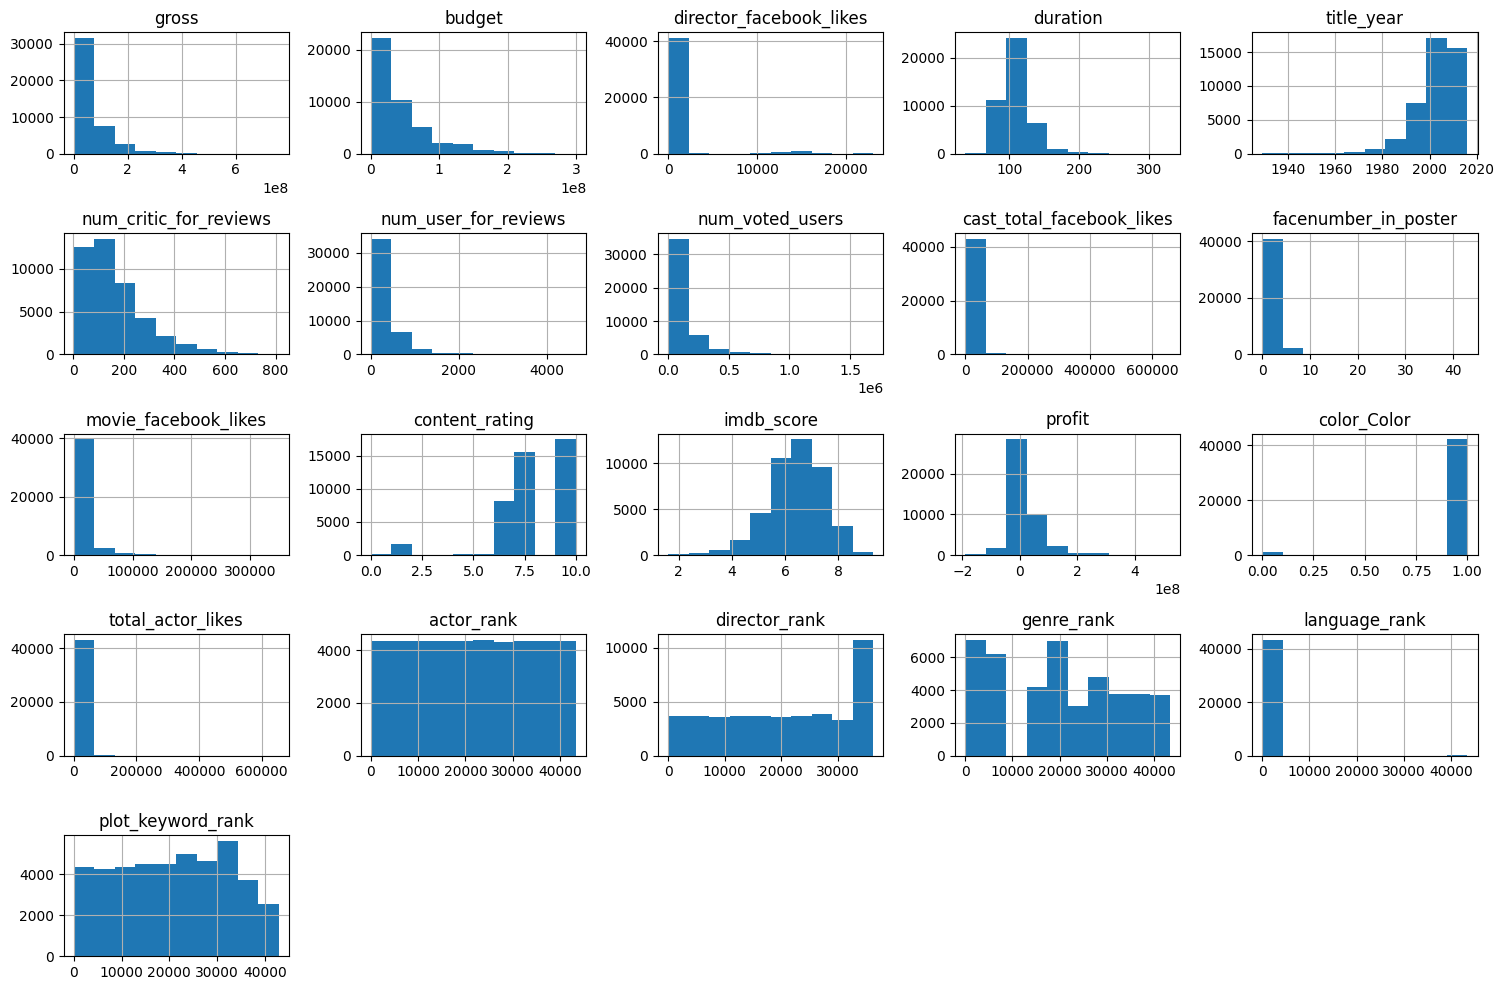

In [60]:
# Create histogram to understand the distribution of numeric values
# Select numeric columns
numeric_columns = converted_data.select_dtypes(include=['number']).columns.tolist()

# Create histograms for numeric columns
converted_data[numeric_columns].hist(figsize=(15, 10))
plt.tight_layout()
plt.show()



In [61]:
# Print summary statistics
summary_statistics = converted_data.describe()
print(summary_statistics)


              gross        budget  director_facebook_likes      duration  \
count  4.341300e+04  4.341300e+04             43413.000000  43413.000000   
mean   6.341413e+07  4.578176e+07               912.735148    109.807016   
std    7.676749e+07  4.589931e+07              3354.653014     22.459886   
min    7.030000e+02  2.180000e+02                 0.000000     37.000000   
25%    1.400000e+07  1.400000e+07                12.000000     95.000000   
50%    3.810508e+07  3.000000e+07                63.000000    106.000000   
75%    8.256953e+07  6.000000e+07               235.000000    119.000000   
max    7.605058e+08  3.000000e+08             23000.000000    330.000000   

        title_year  num_critic_for_reviews  num_user_for_reviews  \
count      43413.0            43413.000000          43413.000000   
mean   2002.839518              167.494115            340.112962   
std         9.9602              125.772128            407.460466   
min         1929.0                2.000000 

In [62]:
# Given that we're working with different scales and some features have wide range/distribution it is good to normalize them
# List of numeric columns to normalize
columns_to_normalize = [
    'gross', 'budget', 'director_facebook_likes', 'duration',
    'num_critic_for_reviews', 'num_user_for_reviews',
    'num_voted_users', 'cast_total_facebook_likes',
    'total_actor_likes', 'actor_rank',
    'director_rank', 'genre_rank', 'language_rank', 'plot_keyword_rank'
]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalize the specified columns
converted_data[columns_to_normalize] = scaler.fit_transform(converted_data[columns_to_normalize])

# Print summary statistics after normalization
summary_statistics_normalized = converted_data.describe()
print(summary_statistics_normalized)




              gross        budget  director_facebook_likes      duration  \
count  43413.000000  43413.000000             43413.000000  43413.000000   
mean       0.083383      0.152605                 0.039684      0.248488   
std        0.100943      0.152998                 0.145854      0.076655   
min        0.000000      0.000000                 0.000000      0.000000   
25%        0.018408      0.046666                 0.000522      0.197952   
50%        0.050104      0.099999                 0.002739      0.235495   
75%        0.108571      0.199999                 0.010217      0.279863   
max        1.000000      1.000000                 1.000000      1.000000   

        title_year  num_critic_for_reviews  num_user_for_reviews  \
count      43413.0            43413.000000          43413.000000   
mean   2002.839518                0.204062              0.072479   
std         9.9602                0.155083              0.087344   
min         1929.0                0.000000 

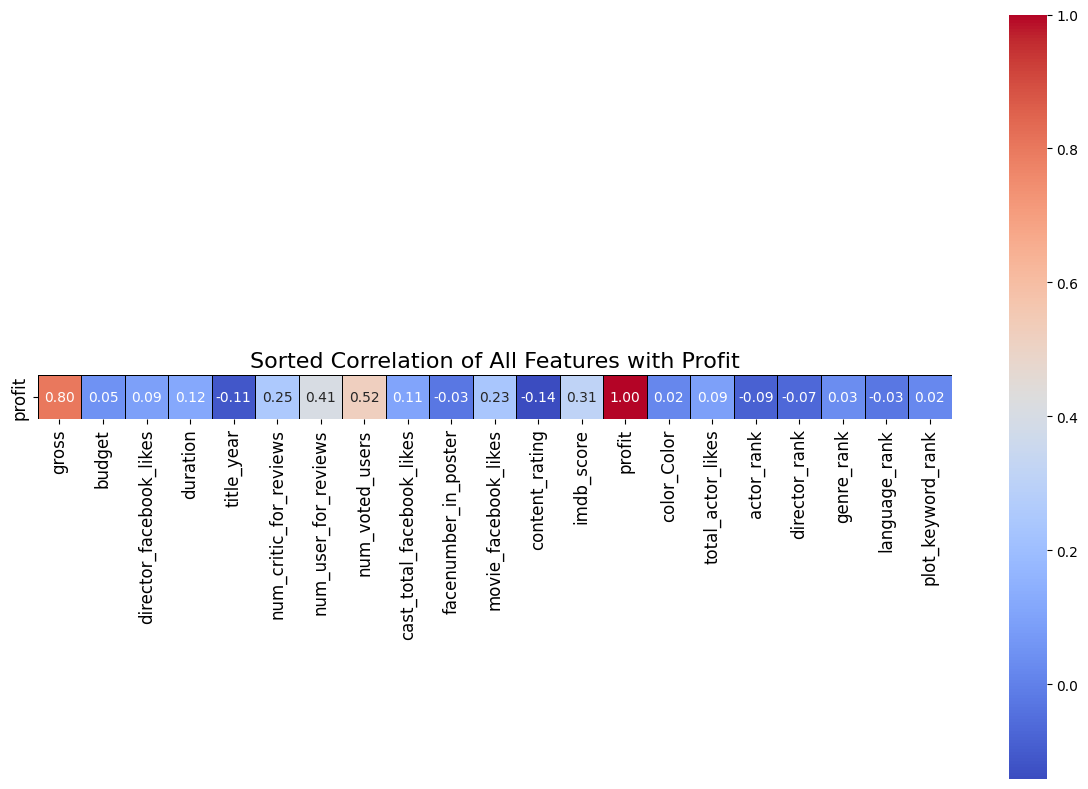

In [65]:
# Select only numeric columns from the dataset
numeric_data = converted_data.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix for the numeric columns
correlation_matrix = numeric_data.corr()

# Select the correlation values specifically with 'profit' and transpose the result for easier visualization
correlation_profit = correlation_matrix[['profit']].T

# Sort the correlations from highest to lowest
sorted_correlation_profit = correlation_profit.sort_values(by='profit', ascending=False)

# Set up the matplotlib figure for the heatmap
plt.figure(figsize=(12, 8))

# Draw a heatmap to visualize the sorted correlation of all features with 'profit'
sns.heatmap(sorted_correlation_profit, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, cbar=True, linewidths=0.5, linecolor='black')

# Set the title and adjust font size for clarity
plt.title('Sorted Correlation of All Features with Profit', fontsize=16)
plt.xticks(fontsize=12)  # Adjust x-axis font size
plt.yticks(fontsize=12)  # Adjust y-axis font size

# Improve layout for better spacing and display the plot
plt.tight_layout()
plt.show()

The strongest positive correlation (>.50) with profit is gross (1st week gross) while those with moderate correlation(>.3), num_voted_users, imdb_score, and num_user_for_reviews. movie_facebook_likes cast_total_facebook_likes, duration, total_actor_likes , director_facebook_likes, num_critic_for_reviews and color_Color have weak correlation (<.3). The rest have very weak correlations (<0).

In [84]:
# Calculate the median profit
median_profit = converted_data['profit'].median()

# Print the result
print(f"The median profit is: {median_profit:.2f}")

The median profit is: 3738726.00


In [ ]:
# PART III: MACHINE LEARNING MODELS USING CLEAN DATA using Google Colab
# This part includes 1) model selection 2) model optimization and 3) evaluation
# Model #1: Random Forest
# It is well suited fr feature importance analysis of IMDB 5000 dataset because it combines decision tress which helps captures complex relatinships in the data and reduce overfitting.

In [96]:
# Train-Test Split
# Get the features w/ >.3 correlation
features = [
    'gross',
    'num_user_for_reviews',
    'num_voted_users',
    'imdb_score',
]

target = 'profit'

# Splitting the data into features (X) and target (y)
X = converted_data[features]
y = converted_data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [97]:
# Train Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

Feature ranking:
1. Feature gross: 0.7633
2. Feature num_user_for_reviews: 0.0856
3. Feature num_voted_users: 0.0813
4. Feature imdb_score: 0.0697


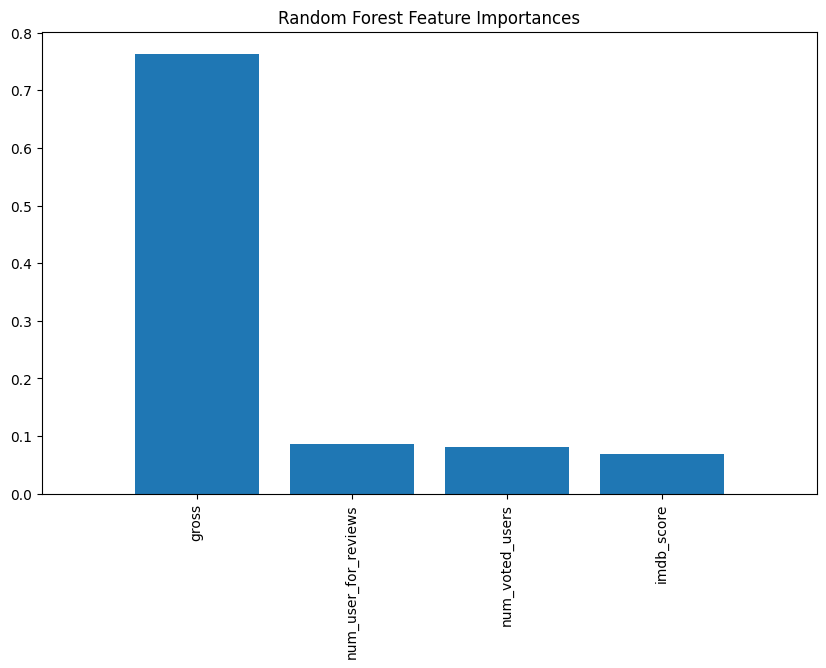

In [98]:
# Get feature importance from the Random Forest model
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort the feature importances in descending order

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. Feature {features[indices[f]]}: {importances[indices[f]]:.4f}")

# Plot the feature importances of the forest
plt.figure(figsize=(10, 6))
plt.title("Random Forest Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), np.array(features)[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

In [99]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Predictions
rf_predictions = rf_model.predict(X_test)

# Random Forest Evaluation
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, rf_predictions)
rf_mae = mean_absolute_error(y_test, rf_predictions)

print(f"Random Forest - MSE: {rf_mse:.2f}, RMSE: {rf_rmse:.2f}, R²: {rf_r2:.2f}, MAE: {rf_mae:.2f}")

Random Forest - MSE: 177616773420.28, RMSE: 421446.05, R²: 1.00, MAE: 52346.50


R² is perfect but MSE is high

In [85]:
# Model #2: Gradient Boosting
# Gradient Boosting can capture complex, non-linear relationships between features and the target variable and it also has built-in methods to calculate feature importance.

# Train Gradient Boosting Model
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

Gradient Boosting Feature ranking:
1. Feature gross: 0.9005
2. Feature num_user_for_reviews: 0.0338
3. Feature imdb_score: 0.0329
4. Feature num_voted_users: 0.0328


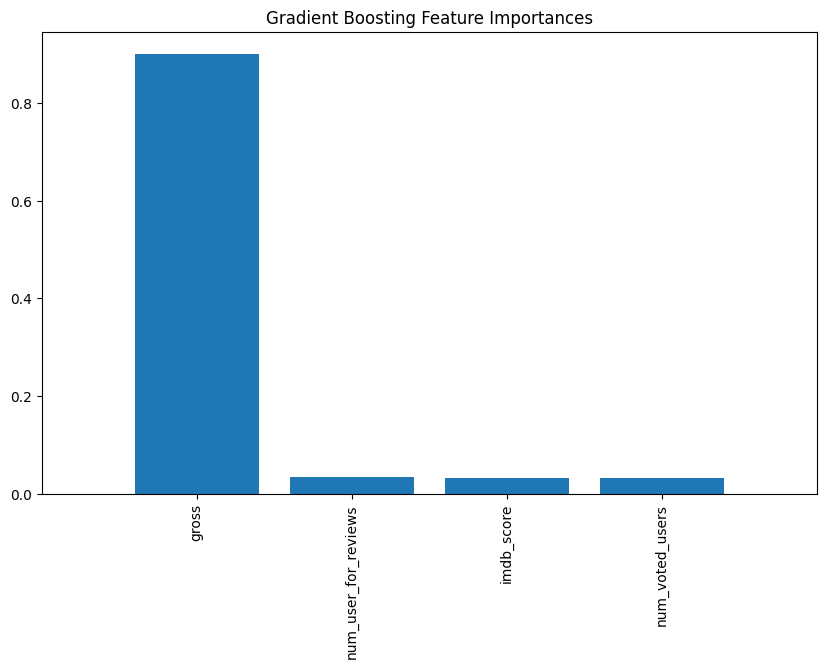

In [86]:
# Get feature importance from the Gradient Boosting model
gb_importances = gb_model.feature_importances_
gb_indices = np.argsort(gb_importances)[::-1]  # Sort the feature importances in descending order

# Print the feature ranking for Gradient Boosting
print("Gradient Boosting Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. Feature {features[gb_indices[f]]}: {gb_importances[gb_indices[f]]:.4f}")

# Plot the feature importances of the Gradient Boosting model
plt.figure(figsize=(10, 6))
plt.title("Gradient Boosting Feature Importances")
plt.bar(range(X.shape[1]), gb_importances[gb_indices], align="center")
plt.xticks(range(X.shape[1]), np.array(features)[gb_indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

In [87]:
# Predictions
gb_predictions = gb_model.predict(X_test)

# Gradient Boosting Evaluation
gb_mse = mean_squared_error(y_test, gb_predictions)
gb_rmse = np.sqrt(gb_mse)
gb_r2 = r2_score(y_test, gb_predictions)
gb_mae = mean_absolute_error(y_test, gb_predictions)

print(f"Gradient Boosting - MSE: {gb_mse:.2f}, RMSE: {gb_rmse:.2f}, R²: {gb_r2:.2f}, MAE: {gb_mae:.2f}")

Gradient Boosting - MSE: 861470429846881.88, RMSE: 29350816.51, R²: 0.75, MAE: 20551852.16


 Gradient Boosting model shows decent performance with an R² of 0.75, but the high MSE and RMSE indicate that there are substantial prediction errors.

In [89]:
# Model optimization through feature selection
# Model #1: Random Forest
# Train-Test Split
# Get the features with correlation score >.1
features = [
    'gross',
    'num_voted_users',
    'imdb_score',
    'num_user_for_reviews',
    'num_critic_for_reviews',
    'duration',
    'movie_facebook_likes',
    'cast_total_facebook_likes',
    'director_facebook_likes',
]

target = 'profit'

# Splitting the data into features (X) and target (y)
X = converted_data[features]
y = converted_data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [90]:
# Train Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)



RandomForestRegressor(random_state=42)

Feature ranking:
1. Feature gross: 0.7143
2. Feature num_critic_for_reviews: 0.0706
3. Feature imdb_score: 0.0456
4. Feature duration: 0.0412
5. Feature cast_total_facebook_likes: 0.0342
6. Feature num_user_for_reviews: 0.0289
7. Feature num_voted_users: 0.0250
8. Feature director_facebook_likes: 0.0209
9. Feature movie_facebook_likes: 0.0193


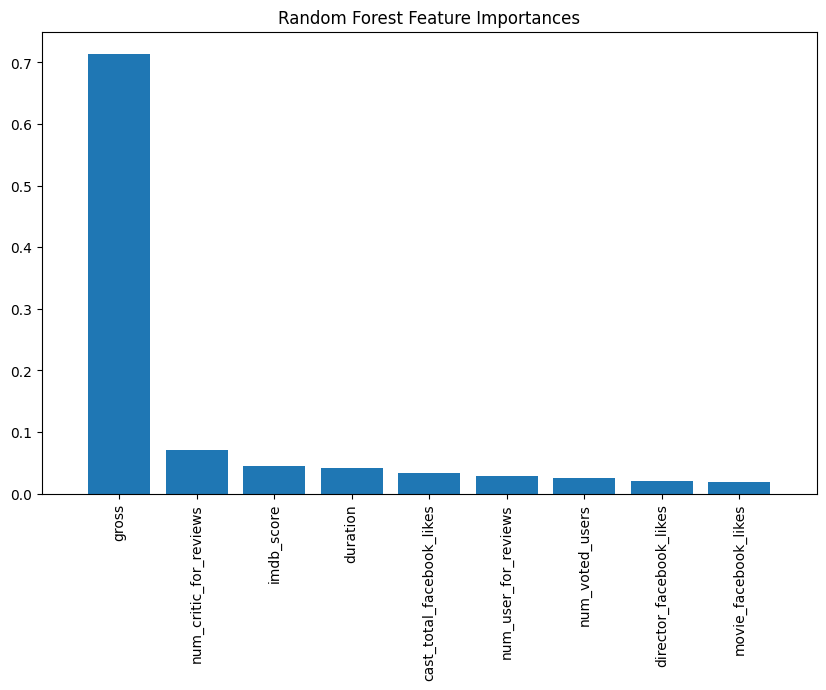

In [91]:
# Get feature importance from the Random Forest model
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort the feature importances in descending order

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. Feature {features[indices[f]]}: {importances[indices[f]]:.4f}")

# Plot the feature importances of the forest
plt.figure(figsize=(10, 6))
plt.title("Random Forest Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), np.array(features)[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()


In [92]:
# Predictions
rf_predictions = rf_model.predict(X_test)

# Random Forest Evaluation
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, rf_predictions)
rf_mae = mean_absolute_error(y_test, rf_predictions)

print(f"Random Forest - MSE: {rf_mse:.2f}, RMSE: {rf_rmse:.2f}, R²: {rf_r2:.2f}, MAE: {rf_mae:.2f}")


Random Forest - MSE: 96462952150.42, RMSE: 310584.85, R²: 1.00, MAE: 37744.22


Random Forest model improved with lower MSE, RMSE and MAE while maintianing high R²

In [93]:
# Model #2: Gradient Boosting
# Gradient Boosting can capture complex, non-linear relationships between features and the target variable and it also has built-in methods to calculate feature importance.

# Train Gradient Boosting Model
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)


GradientBoostingRegressor(random_state=42)

Gradient Boosting Feature ranking:
1. Feature gross: 0.8348
2. Feature num_critic_for_reviews: 0.0617
3. Feature imdb_score: 0.0318
4. Feature duration: 0.0236
5. Feature cast_total_facebook_likes: 0.0158
6. Feature num_voted_users: 0.0141
7. Feature num_user_for_reviews: 0.0079
8. Feature movie_facebook_likes: 0.0055
9. Feature director_facebook_likes: 0.0048


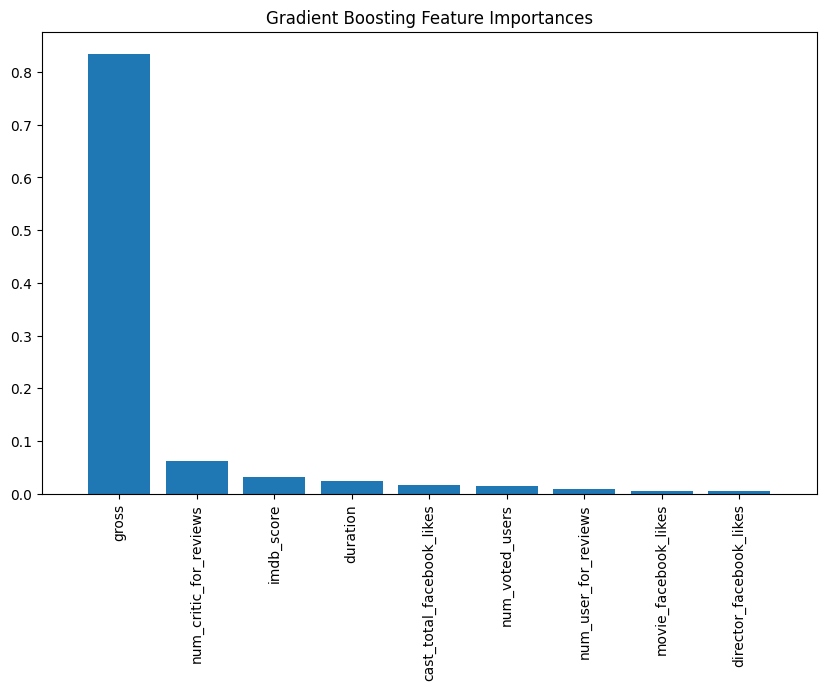

In [94]:
# Get feature importance from the Gradient Boosting model
gb_importances = gb_model.feature_importances_
gb_indices = np.argsort(gb_importances)[::-1]  # Sort the feature importances in descending order

# Print the feature ranking for Gradient Boosting
print("Gradient Boosting Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. Feature {features[gb_indices[f]]}: {gb_importances[gb_indices[f]]:.4f}")

# Plot the feature importances of the Gradient Boosting model
plt.figure(figsize=(10, 6))
plt.title("Gradient Boosting Feature Importances")
plt.bar(range(X.shape[1]), gb_importances[gb_indices], align="center")
plt.xticks(range(X.shape[1]), np.array(features)[gb_indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()


In [95]:
# Predictions
gb_predictions = gb_model.predict(X_test)

# Gradient Boosting Evaluation
gb_mse = mean_squared_error(y_test, gb_predictions)
gb_rmse = np.sqrt(gb_mse)
gb_r2 = r2_score(y_test, gb_predictions)
gb_mae = mean_absolute_error(y_test, gb_predictions)

print(f"Gradient Boosting - MSE: {gb_mse:.2f}, RMSE: {gb_rmse:.2f}, R²: {gb_r2:.2f}, MAE: {gb_mae:.2f}")

Gradient Boosting - MSE: 629045087418644.62, RMSE: 25080771.27, R²: 0.81, MAE: 17470343.16


Gradient Boosting model shows better results after optimization with higher R² of 0.81, and lower MSE and RMSE

Adding more relevant features improved both models, removing bias than the original model which was too limited to capture underlying patterns.
Overall, the new models is indeed an improvement in terms of MSE and RMSE, suggesting better predictive performance, while still maintaining high R². The small increase in MAE is not significant compared to the overall improvement.
Random Forest is clearly the better model in this comparison due to its lower MSE, RMSE, and MAE, along with a perfect R² score
